In [1]:
from main_household import *
import numpy as np
import os
np.set_printoptions(suppress=True)

In [50]:
    # fmode = "forward fill"
    # zone = 0
    # period = "hour of the day"

    # clear_terminal()
    # tvec, data, _, _ = load_measurements("testdata1.csv", fmode)
    # tvec_a, data_a = aggregate_measurements(tvec, data, period)

    # plot_statistics(tvec_a, data_a, zone=zone, time_unit=period)

In [43]:
# Plots statistics from the loaded data
def plot_statistics(tvec: np.ndarray, data: np.ndarray, zone=0, time_unit="minute"):
    # Author:         Lucas D. Vilsen, s224195
    # Usage:          main function
    # Input:          tvec and data (via. load_measurements()),
    #                 desired zone (string or integer), and the time unit as a string
    # Return:         None
    # Screen output:  Matplotlib plot

    # We choose the zone appropriate data
    if zone == 0:
        title = "all zones"
    else:
        title = f"zone {zone}"
        data = data[:, zone-1]

    # Condtition for bar plot:
    cond_bar_plot = np.size(data) < 25

    # We make the plot a bit transparent if we plot by minutes etc.
    if time_unit == "minute":
        alpha = 0.4
    else:
        alpha = 1

    labels = ["Zone 1", "Zone 2", "Zone 3", "Zone 4"]
    colors = ["tab:red", "tab:green", "tab:blue", "tab:orange"]
    width = 0.15

    # If the values get too high, change unit:
    if np.max(data) > 50000:
        data /= 1000
        unit = "k"
    else:
        unit = ""

    if zone == 0:
        # We loop over each zone
        for i in range(4):
            if cond_bar_plot:
                new_tvec = np.arange(len(tvec))
                plt.bar(new_tvec + width*(i-1.5), data[:,i], width=width)
            else:
                plt.plot(tvec, data[:,i], label=labels[i], color=colors[i], alpha=alpha)
    # or just plot the zone we want to look at
    else: 
        if cond_bar_plot:
            new_tvec = np.arange(len(tvec))
            plt.bar(new_tvec, data)
        else:
            plt.plot(tvec, data, label=f"Zone {zone}", color="r",alpha=alpha)

    # we make the layout
    plt.title(f"Consumption for {title} per {time_unit}")
    plt.xlabel(f"Time ({time_unit}s)")
    plt.ylabel(f"Energy ({unit}Wh)")
    plt.tight_layout()

    if time_unit == "hour of the day": # Unique case:
        plt.title(f"Average consumption for {title} per hour")
        plt.xlabel(f"Time (hours)")
        plt.ylabel(f"Energy (Wh)")
    
    # Makes x-axis more readable:
    if (time_unit in ["hour", "day", "hour of the day"]) and (not cond_bar_plot):
        plt.xticks(rotation = 45)
    
    if cond_bar_plot:
        plt.xticks(range(len(tvec)), [str(int(n)) for n in tvec])
    elif period != "minute":
        plt.xticks(tvec)

    if not cond_bar_plot:
        plt.grid()
        plt.legend(labels)
    plt.show()

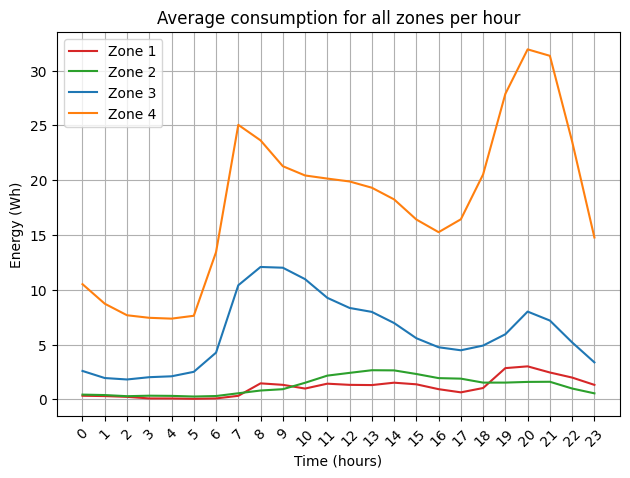

In [49]:
tvec, data, _, _ = load_measurements("testdata_2008.csv", "forward fill")
period = "hour of the day"
tvec_a, data_a = aggregate_measurements(tvec, data, period)
zone = 0
plot_statistics(tvec_a, data_a, zone, period)

In [7]:
tvec, data, _, _ = load_measurements("testdata_2008.csv", "drop")

In [121]:
period = "hour"
tvec_a, data_a = aggregate_measurements(tvec, data, period)

plot_statistics2(tvec_a, data_a, zone="All", time_unit=period)

TypeError: unsupported operand type(s) for -: 'str' and 'int'

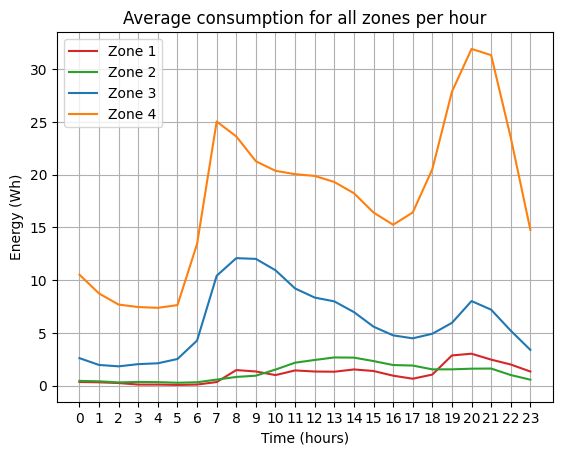

In [80]:
period = "hour of the day"
zone = "All"


plot_statistics2(tvec_a, data_a, zone=zone, time_unit=period)

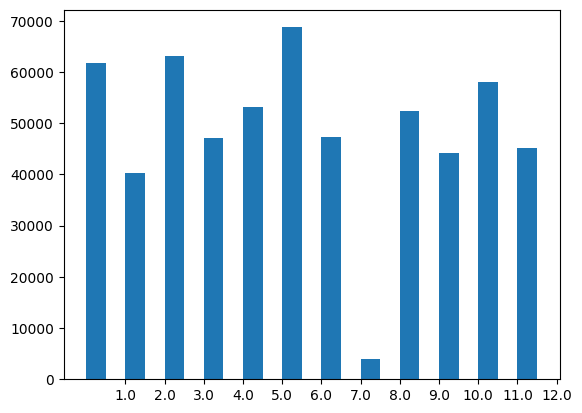

In [20]:
import matplotlib.pyplot as plt
period = "month"
tvec_a, data_a = aggregate_measurements(tvec, data, period)

size = np.size(data_a)
width = 0.15

# if size < 25:
# for i in range(4):
i = 0; width = 0.5
range1 = np.arange(len(tvec_a))
plt.bar(range1 + width*(i-1.5), data_a[:,i], width=width)

plt.xticks(range1, tvec_a)
plt.show()

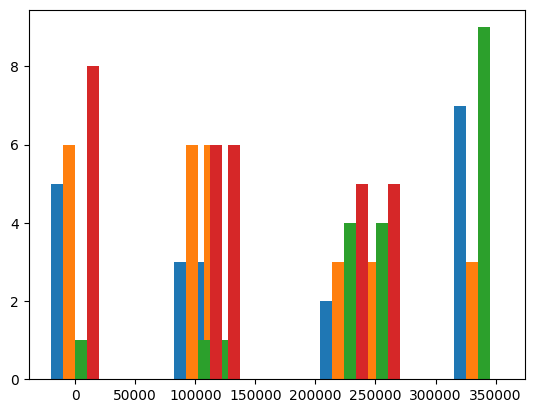

In [8]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.bar(tvec_a + 10000*(i-1.5), data_a[:,i], width=10000)

In [11]:
# Loads measurements from csv files:
def load_measurements(filename: str, fmode: str):
    # Author:   Alexander Wittrup, s224196
    # Usage:    aggregate_measurements(), print_statistics()
    # Input:    filename and fmode (fill mode) strings.
    # Returns:  tvec, data, and error message if there is any (suffix).

    # Ensuring a correct path and converting the csv to a numpy array:
    data = [row.split(",") for row in open(filename, "r")]
    data = np.array(data,dtype=float)

    # Mask that excludes all rows with corrupt measurements:
    mask_valid_rows = np.all(data != -1, axis=1)
    pct = np.count_nonzero(mask_valid_rows) / len(mask_valid_rows)

    err_ffill = (
        "Error: Forward fill cannot be performed since the first row is corrupted,\n"
        f"all corrupted rows ({pct:.2%} of data) have been removed instead.")
    err_bfill = (
        "Error: Backward fill cannot be performed since the last row is corrupted,\n"
        f"all corrupted rows ({pct:.1%} of data) have been removed instead.")
    suffix = ""

    if fmode == "drop":
        data = data[mask_valid_rows]
        return data[:,:6], data[:,6:], ""
    
    elif fmode == "forward fill":
        # Drops corrupt data if the first row is corrupt:
        if np.any(data[0] == -1):
            data = data[mask_valid_rows]
            suffix = err_ffill
        else:
            # Forward fills to previous valid measurement:
            for x, y in np.argwhere(data == -1):
                n=1
                while data[x-n, y] == -1: n+=1
                data[x, y] = data[x-n, y]

    elif fmode == "backward fill":
        # Drops corrupt data if the last row is corrupt:
        if np.any(data[-1] == -1):
            data = data[mask_valid_rows]
            suffix = err_bfill
        else:
            # Backward fills to next valid measurement:
            for x, y in np.argwhere(data == -1):
                n=1
                while data[x+n, y] == -1: n+=1
                data[x, y] = data[x+n, y]
    return data[:,:6], data[:,6:], suffix

tvec, data, suffix = load_measurements("testdata2.csv", "backward fill")
print(suffix)
tvec, data

Error: Backward fill cannot be performed since the last row is corrupted,
all corrupted rows (50.0% of data) have been removed instead.


(array([[2006.,    2.,   11.,    6.,    1.,    0.],
        [2006.,    7.,   14.,    9.,    3.,    0.],
        [2006.,    8.,    2.,    9.,    3.,    0.]]),
 array([[5., 6., 1., 8.],
        [2., 3., 4., 5.],
        [2., 3., 4., 5.]]))

In [12]:
list1 = np.concatenate(data)
list1

array([5., 6., 1., 8., 2., 3., 4., 5., 2., 3., 4., 5.])

In [13]:
mask.shape

NameError: name 'mask' is not defined

In [ ]:
np.arange(mask.shape[1])

IndexError: tuple index out of range

In [ ]:
mask = list1 != -1
idx = np.where(~mask, np.arange(mask.shape[1]), 0)

IndexError: tuple index out of range

In [ ]:
mask = np.isnan(arr)
idx = np.where(~mask, np.arange(mask.shape[1]), 0)
np.maximum.accumulate(idx, axis=1, out=idx)
out = arr[np.arange(idx.shape[0])[:,None], idx]

IndexError: tuple index out of range

In [ ]:
mask = list1 != -1
list1, list1[mask]

(array([-1.,  2.,  3.,  4.,  5.,  6., -1.,  8.,  3., -1., -1.,  6.,  2.,
         3.,  4.,  5.]),
 array([2., 3., 4., 5., 6., 8., 3., 6., 2., 3., 4., 5.]))

In [ ]:
[data[(x,y-1)] for x, y in np.argwhere(data == -1)]

[3.0, -1.0, 7.0]

In [ ]:
fmode = "drop"
path = "testdata2.csv"
data = [row.split(",") for row in open(path, "r")]
data = np.array(data,dtype=float)

if fmode == "drop":
    data = data[np.all(data != -1, axis=1)]
    return data[:,:6], data[:,6:]

if fmode == "forward fill" and np.all(data[0] != -1): num = -1
elif fmode == "backward fill" and np.all(data[-1] != -1): num = 1

data = data[np.all(data != -1, axis=1)]
for x, y in np.argwhere(data == -1):
    data[x][y] = data[x + num][y]
err_msg = "err"
suffix = err_msg

return data[:,:6], data[:,6:], suffix

(array([[2006.,    2.,   11.,    6.,    1.,    0.],
        [2006.,    7.,   14.,    9.,    3.,    0.]]),
 array([[5., 6., 1., 8.],
        [2., 3., 4., 5.]]))

In [ ]:
def aggregate_measurements(tvec: np.ndarray, data: np.ndarray, period="minute"):
    if period == "minute":
        # This conversion works assuming the data is sorted 
        init_val = tvec[0,:]
        relative_tvec = tvec - init_val
        # Converts the columns of relative_tvec to minutes and adds them:
        time_to_min_const = np.array([525948.766, 43829.0639, 1440, 60, 1, 1])
        min_tvec = np.sum(relative_tvec * time_to_min_const, axis=1, dtype=int)
        return min_tvec, data

    elif period == "hour of the day":  #AKA: hotd
        tvec_a = np.arange(24)
        hotd_data = []
        for hour in tvec_a:
            # Mask that only accepts elements that correspond to the currently iterated hour.
            mask = tvec[:,3] == hour
            is_not_empty = data[mask].size > 0
            # Takes mean of data only if list isn't empty to avoid RuntimeWarning.
            if is_not_empty: hotd_data.append(np.mean(data[mask], axis=0))
            else: hotd_data.append(np.zeros(4))
        return tvec_a, np.asarray(hotd_data)

    elif period == "hour": col = 3
    elif period == "day": col = 2
    elif period == "month": col = 1

    # Collects all the unique elements from the relevant time column.
    tvec_a = np.unique(tvec[:,col])
    # Does basically the same as hotd but takes sum instead of average.
    data_a = np.array([np.sum(data[tvec[:,col] == n], axis=0) for n in tvec_a])
    return tvec_a, data_a

In [ ]:
tvec1, data1 = load_measurements("testdata3.csv", "backward fill")
tvec_a, data_a = aggregate_measurements(tvec1, data1, "hour of the day")
tvec_a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

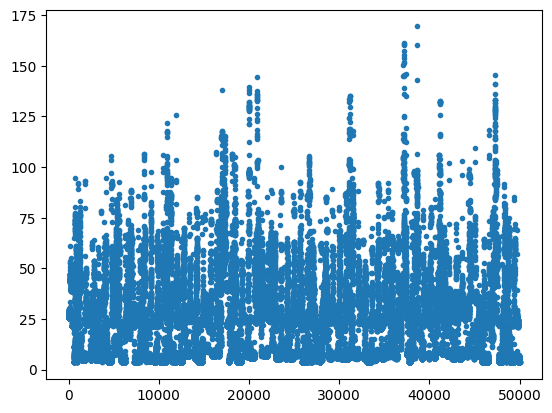

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tvec_a[:50000], data_a[:50000,3], linestyle="", marker=".");

In [ ]:
type(data_a)

numpy.ndarray

In [ ]:
import platform
print(platform.system())

Darwin


In [ ]:
tvec

array([[2008.,    1.,    1.,    0.,    0.,    0.],
       [2008.,    1.,    1.,    0.,    1.,    0.],
       [2008.,    1.,    1.,    0.,    2.,    0.],
       ...,
       [2008.,   12.,   31.,   23.,   57.,    0.],
       [2008.,   12.,   31.,   23.,   58.,    0.],
       [2008.,   12.,   31.,   23.,   59.,    0.]])

In [ ]:
# tvec[:,-2]

month_idx = []

year, month, day, hour, minute, _ = 

tvec[-1,:] - tvec[0,:]

SyntaxError: invalid syntax (2430645008.py, line 5)

In [ ]:
def aggregate_measurements(tvec, data, period):
    if period == "hour":
        col = 3
    if period == "day":
        col = 2
    if period == "month":
        col = 1
    if period == "hour of the day":
        col = 3
    
    nums = np.unique(tvec[:,col])
    data_a = np.array([])
    tvec_a = np.array([])
    for n in nums:
        tvec_a = np.append(tvec_a, n)

        mask = tvec[:,col] == n
        data_a = np.append(data_a, np.sum(data[mask], axis=0))
    data_a = np.reshape(data_a, (-1,4))
    return tvec_a, data_a, period



In [ ]:
9 in list(range(0))

False

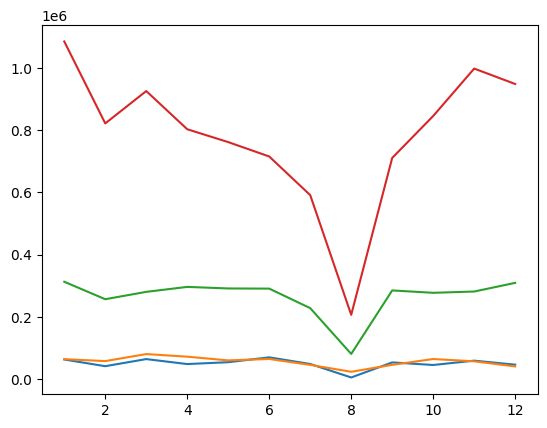

In [ ]:
import matplotlib.pyplot as plt
from main_script import aggregate_measurements

tvec_a, data_a, _ = aggregate_measurements(tvec,data,"month")

for i in range(4):
    plt.plot(tvec_a[:,1],data_a[:,i])

In [ ]:
tvec_a[:23]

array([[ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.],
       [ 0.,  6.,  0.,  0.,  0.,  0.],
       [ 0.,  7.,  0.,  0.,  0.,  0.],
       [ 0.,  8.,  0.,  0.,  0.,  0.],
       [ 0.,  9.,  0.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  0.,  0.],
       [ 0., 11.,  0.,  0.,  0.,  0.],
       [ 0., 12.,  0.,  0.,  0.,  0.]])